In [1]:
import numpy as np
from empiricaldist import Pmf
from scipy.stats import binom
import matplotlib.pyplot as plt
import pandas as pd

def decorate(**options):
    """Decorate the current axes.
    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')
    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    ax = plt.gca()
    ax.set(**options)

    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels)

    plt.tight_layout()

### Exercise 1:

In the 2014 FIFA World Cup, Germany played Brazil in a semifinal match. Germany scored after 11 minutes and again at the 23 minute mark. At that point in the match, how many goals would you expect Germany to score after 90 minutes? What was the probability that they would score 5 more goals (as, in fact, they did)?

Here are the steps I recommend:

- Starting with the same gamma prior we used in the previous problem, compute the likelihood of scoring a goal after 11 minutes for each possible value of lam. Don’t forget to convert all times into games rather than minutes.

- Compute the posterior distribution of lam for Germany after the first goal.

- Compute the likelihood of scoring another goal after 12 more minutes and do another update. Plot the prior, posterior after one goal, and posterior after two goals.

- Compute the posterior predictive distribution of goals Germany might score during the remaining time in the game, 90-23 minutes. Note: You will have to think about how to generate predicted goals for a fraction of a game.

- Compute the probability of scoring 5 or more goals during the remaining time.

Prior mean: 1.4140818156118378


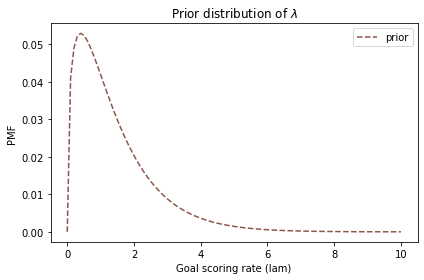

In [2]:
#### Rebuild prior from chapter

from scipy.stats import gamma
from empiricaldist import Pmf

### Gamma is a good distribution for goal-scoring since:
# non-negative & continuous
# decays, similar to expectations around goal-scoring (we assume more likely to score 2 goals than 10)

# Gamma has a PDF since continuous, but below is an approximation of PMF
alpha = 1.4 # alpha for gamma
qs = np.linspace(0, 10, 101) # pass in quantities to review
ps = gamma(alpha).pdf(qs) # calculate prob densities

# Pass into a Pmf to build prior 
prior = Pmf(ps, qs)
prior.normalize()

# plot for fun
# Note: This is a "discrete approximation" of a gamma distribution
def decorate_rate(title=''):
    decorate(xlabel='Goal scoring rate (lam)',
        ylabel='PMF',
        title=title)

prior.plot(ls='--', label='prior', color='C5')
decorate_rate(r'Prior distribution of $\lambda$');

print(f"Prior mean: {prior.mean()}")

In [3]:
### Make a copy of prior for Germany: 
germany = prior.copy()

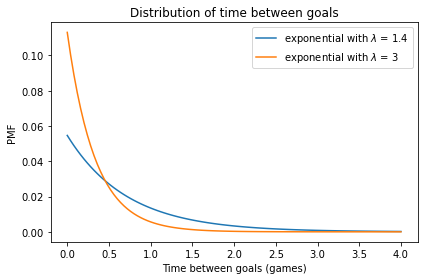

In [4]:
def expo_pdf(t, lam):
    """Compute the PDF of the exponential distribution."""
    return lam * np.exp(-lam * t)

lam = 1.4 # goal-scoring rate
qs = np.linspace(0, 4, 101) # games to score a goal
ps = expo_pdf(qs, lam) # probabilities
pmf_time = Pmf(ps, qs)
pmf_time.normalize();

lam2 = 3 # higher goal scoring rate
qs = np.linspace(0, 4, 101) # games to score a goal
ps = expo_pdf(qs, lam2) # probabilities
pmf_time2 = Pmf(ps, qs)
pmf_time2.normalize();

def decorate_time(title=''):
    decorate(xlabel='Time between goals (games)',
             ylabel='PMF',
             title=title)

# As we would expect, there is a lower expected number of games for a higher scoring team
pmf_time.plot(label=f'exponential with $\lambda$ = {lam}')
pmf_time2.plot(label=f'exponential with $\lambda$ = {lam2}')

decorate_time('Distribution of time between goals')

In [5]:
def update_expo(pmf, data):
    """Update based on an observed interval
    
    pmf: prior PMF
    data: time between goals in minutes
    """
    t = data / 90 # assume each game is 90 min, convert to proportion of a game
    lams = pmf.qs # goal-scoring rates from prior
    likelihood = expo_pdf(t, lams) # for a single time what is likelihood of various lambdas
    pmf *= likelihood # take likelihood of lambda & multiply by prior lambda
    pmf.normalize()

In [6]:
# prior shows likelihood of a lambda from 0-10
germany = prior.copy()

# we pass in 11 minutes as t to estimate likelihood of scoring in 11 min relative to all lambdas?
update_expo(germany, 11)

# we then do this for 12 min
germany2 = germany.copy()
update_expo(germany2, 12)

In [7]:
# Mean values of lambda after the update
# As we might expect: scoring this many goals pushes expected scoring rate up
germany.mean(), germany2.mean()

(2.1358882653086892, 2.703059034926364)

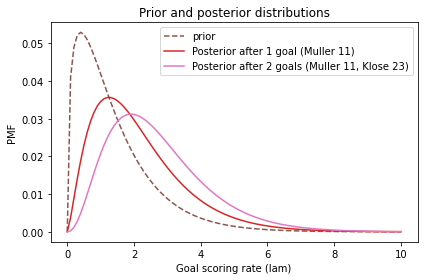

In [8]:
# Here's what the posterior distributions look like

prior.plot(ls='--', label='prior', color='C5')
germany.plot(color='C3', label='Posterior after 1 goal (Muller 11)')
germany2.plot(color='C16', label='Posterior after 2 goals (Muller 11, Klose 23)')

decorate_rate('Prior and posterior distributions')

#### Summarize Steps Above: Getting to the posterior distribution

1) We get a prior of our `lambda`, or scoring rate, based on a `gamma` distribution

2) We assume each team has a constant goal-scoring rate, which allows us to use an `exponential` distribution to estimate time between goals:

    - the exponential distribution is the probability distribution of the time between events in a Poisson point process
    - i.e., a process in which events occur continuously and independently at a constant average rate.
    - If our goal scoring rate was `lambda` then we can get the "probability" of seeing an interval between goals of `t` (in games)
    
3) The above information is then used for a Baye's update:
    - prior: probability of various `lambdas` (goal-scoring rate)
    - likelihood: `P(time | lambda)` => given our various lambdas, what is likelihood of getting the input `time` (in games)
    - poserior: `P(lambda | time)` => given the time, what does the Pmf of lambda look like?
    
4) Fitting our intuition, when Germany scores goals as quickly as they do here we expec they have a much higher goal-scoring rate. 


#### Moving into the posterior prediction distribution

How does this differ from posterior: 
- It takes into account the data we have seen (our posterior) as basically a weight for the total goals that might be scored of `90 - 23` minutes

How to estimate predicted goals for a fraction of a game?
- I think we would just multiply the `lambda` by our fraction of remaining game. 
- E.g. If we assume a goal-scoring rate of 3 we multiply that by `(90-23)/ 90`

In [9]:
import pandas as pd 
from numpy.typing import ArrayLike
from scipy.stats import poisson


def make_mixture(pmf, pmf_seq):
    """Make a mixture of distributions."""
    df = pd.DataFrame(pmf_seq).fillna(0).transpose()
    df *= np.array(pmf)
    total = df.sum(axis=1)
    return Pmf(total)

def make_poisson_pmf(lam: int, qs: ArrayLike) -> Pmf:
    """Make a Pmf of a Poisson distribution"""
    
    # gather probs
    ps = poisson(lam).pmf(qs)
    
    # build a pmf using ps (probs) and qs(quantities)
    pmf = Pmf(ps,qs)
    pmf.normalize()
    return pmf

In [11]:
# build our sequence of goals scored based on lambda
goals = np.arange(10)

# Note: we have to multiply lambda by our fraction of game remaining
pmf_seq = [make_poisson_pmf(lam * (90-23) / 90, goals) 
           for lam  in prior.qs]

In [12]:
pred_germany = make_mixture(germany2, pmf_seq)

In [13]:
# likelihood of 5 goals
pred_germany[5]

0.04710965870611341

In [14]:
# likelihood of 5+ (really 5-10)
pred_germany.prob_ge(5)

0.09286200122834537

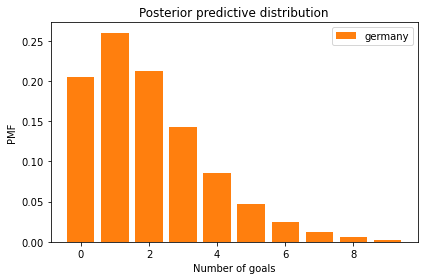

In [15]:
# Here's what the predictive distribution looks like
def decorate_goals(title=''):
    decorate(xlabel='Number of goals',
        ylabel='PMF',
        title=title)
    
pred_germany.bar(color='C1', label='germany')
decorate_goals('Posterior predictive distribution')

### Summarizing the Posterior Predictive Distribution: 

- We start by building a sequence of goals scored based on a range of `lambda` values.
    - To account for minimal time remaining I multiply each lambda by fraction of game remaining. 
    - These distributions each give us likelihood of discrete events (goals scored) based on `singular lambda` values.

- We use the `posterior distribution` from above as our likelihood of the various lambda values. 
    - It is basically a weight applied to the aforementioned sequence
    - Our posterior is our current understanding of the actual lambda value given the `gamma` prior and the time to score goals (using `exponential`)
    
- Mixture calculation: 
    - Our lambda sequence is stored off as each row representing a different `goals scored` and each column representing a different `lambda`
        - This gives us the P(Goals Scored | Lambda)
    - We multiply each row by the likelihood of Lambda given the data (in this case considering our prior and the data around time)
    - Each row can be summed to get a final likelihood of scoring that many goals
        - Important to note that this is taking into account the likelihood of a certain lambda being the true lambda (posterior) given all of the data

### Exercise 2:

Returning to the first version of the World Cup Problem. Suppose France and Croatia play a rematch. What is the probability that France scores first?

Hint: Compute the posterior predictive distribution for the time until the first goal by making a mixture of exponential distributions. You can use the following function to make a PMF that approximates an exponential distribution.

In [18]:
# Build our prior
from scipy.stats import gamma

alpha = 1.4
qs = np.linspace(0, 10, 101) # pass in quantities to review
ps = gamma(alpha).pdf(qs) # calculate prob densities

# Pass into a Pmf
prior = Pmf(ps, qs)
prior.normalize()

# copies for each country:
france = prior.copy()
croatia = prior.copy()

# build posterior
def update_poisson(pmf, data):
    """Update Pmf with a Poisson likelihood."""
    k = data # goals scored
    lams = pmf.qs # this is a gamma distribution of lambda
    likelihood = poisson(lams).pmf(k) # pass array of lambdas in for k
    pmf *= likelihood # update
    pmf.normalize()
    
update_poisson(france, 4) # France scored 4 goals
update_poisson(croatia, 2) # Croatia scored 4 goals

In [19]:
# instead of a sequence of lambdas, we build a sequence of 
# exponential approximations
def make_expo_pmf(lam, high):
    """Make a PMF of an exponential distribution.
    
    lam: event rate
    high: upper bound on the interval `t`
    
    returns: Pmf of the interval between events
    """
    qs = np.linspace(0, high, 101)
    ps = expo_pdf(qs, lam)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

In [35]:
# build our sequence of time to score based on lambda

# Note: Upper bound would be a full game of play, right?
# Note2: No, it should be multiple games since lambda
#        represents goals scored in a single game on avg.
pmf_seq_exp = [make_expo_pmf(lam, 4) 
           for lam in prior.qs]

In [36]:
pred_france = make_mixture(france, pmf_seq_exp)
pred_croatia = make_mixture(croatia, pmf_seq_exp)

0.5904596116867543

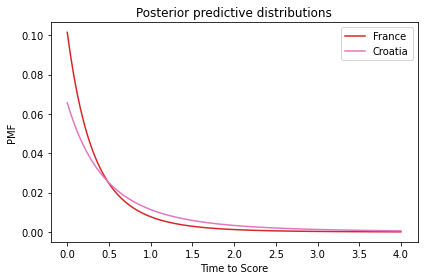

In [38]:
pred_france.plot(color='C3', label='France')
pred_croatia.plot(color='C16', label='Croatia')
def decorate_time(title=''):
    decorate(xlabel='Time to Score',
        ylabel='PMF',
        title=title)
decorate_time('Posterior predictive distributions');

# And here's the probability France scores first
Pmf.prob_lt(pred_france, pred_croatia)

#### Thoughts:

This problem follows a pretty clear script for building a posterior predictive distribution: 

1) Build posterior:

    - We use a gamma prior which reasonable models goal-scoring rates
    - Our data is goals scored in a single game
    - Likelihood: For each lambda what is the likelihood of scoring k goals
    - Update: Likelihood lambda | data * existing likelihood of each lambda
    - Posterior => what do we know about lambda given data
    
2) Use exponential distribution to estimate time between goals for a range of lambdas

    - look across all lambdas in the prior
    - build an approximate Pmf for each using exponential distribution; range is time to score from 0 - 4 games.
    - Initially I wanted to use minutes, but our lambda value is built a goal-scoring rate per game so makes sense to keep units in games here. 
    
3) Use mixture for posterior predictive distribution

- sequence of exponential distributions, the posterior is our weight (likelihood of lambdas given data we have)
- after doing mixture summing we get estimates for likelihood of different times (in games) to score first goal. 
- `prob_lt` will show us how often across all pairings France scores before Croatia

### Exercise: 

In the 2010-11 National Hockey League (NHL) Finals, my beloved Boston Bruins played a best-of-seven championship series against the despised Vancouver Canucks. Boston lost the first two games 0-1 and 2-3, then won the next two games 8-1 and 4-0. At this point in the series, what is the probability that Boston will win the next game, and what is their probability of winning the championship?

To choose a prior distribution, I got some statistics from http://www.nhl.com, specifically the average goals per game for each team in the 2010-11 season. The distribution is well modeled by a gamma distribution with mean 2.8.

In what ways do you think the outcome of these games might violate the assumptions of the Poisson model? How would these violations affect your predictions?

2.7997400090376567

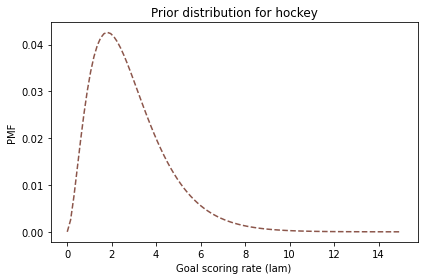

In [7]:
from scipy.stats import gamma, poisson

# build a prior for 0 - 15 goals
alpha = 2.8
qs = np.linspace(0, 15, 101)
ps = gamma.pdf(qs, alpha)
prior_hockey = Pmf(ps, qs)
prior_hockey.normalize()

# plot prior
def decorate_rate(title=''):
    decorate(xlabel='Goal scoring rate (lam)',
        ylabel='PMF',
        title=title)
    
prior_hockey.plot(ls='--', color='C5')
decorate_rate('Prior distribution for hockey')
prior_hockey.mean()

In [9]:
# Perform update for each team with goals scored thus far
def update_poisson(pmf, data):
    """Update Pmf with a Poisson likelihood."""
    k = data # goals scored
    lams = pmf.qs # this is a gamma distribution of lambda
    likelihood = poisson(lams).pmf(k) # pass array of lambdas in for k
    pmf *= likelihood # update
    pmf.normalize()
    
# bruins
bruins = prior_hockey.copy()
goals = [0,2,8,4]
for goal in goals:
    update_poisson(bruins, goal)
print(bruins.mean())

# canucks
canucks = prior_hockey.copy()
goals = [1,3,1,0]
for goal in goals:
    update_poisson(canucks, goal)
print(canucks.mean())


3.3599999999999985
1.5599999606443666


In [11]:
# We'd now build a posterior predictive distribution
# to estimate goals scored in next step
def make_poisson_pmf(lam, qs):
    """Make a Pmf of a Poisson distribution"""
    
    # gather probs
    ps = poisson(lam).pmf(qs)
    
    # build a pmf using ps (probs) and qs(quantities)
    pmf = Pmf(ps,qs)
    pmf.normalize()
    return pmf

goals = np.arange(15)
pmf_seq = [make_poisson_pmf(lam, goals) for lam in bruins.qs]

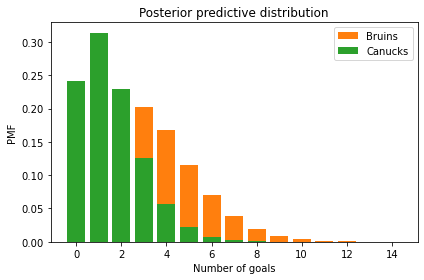

In [14]:
import pandas as pd

def make_mixture(pmf, pmf_seq):
    """Make a mixture of distributions."""
    df = pd.DataFrame(pmf_seq).fillna(0).transpose()
    df *= np.array(pmf)
    total = df.sum(axis=1)
    return Pmf(total)


# Build posterior
pred_bruins = make_mixture(bruins, pmf_seq)
pred_canucks = make_mixture(canucks, pmf_seq)

# Plot
pred_bruins.bar(label='Bruins', color='C1')
pred_canucks.bar(label='Canucks', color = 'C2')

def decorate_goals(title=''):
    decorate(xlabel='Number of goals',
        ylabel='PMF',
        title=title)
    
decorate_goals('Posterior predictive distribution');

In [15]:
# w, l, t
win = Pmf.prob_gt(pred_bruins, pred_canucks)
lose = Pmf.prob_lt(pred_bruins, pred_canucks)
tie = Pmf.prob_eq(pred_bruins, pred_canucks)
p = win + tie/2
p # assume chance of winning next game is

0.771373121978714

In [17]:
from scipy.stats import binom
# TODO: not complete
# winning series? it is tied 2-2; need 2 wins...
n = 3

a = binom.pmf([2], n, p)
a.sum()

0.40811028971073104